In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
# if cuda is available, use it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Data

## split data into train and validation

In [2]:
# Load the data
data = pd.read_csv('train-minst.csv')
# data = pd.read_csv('test-minst.csv') # only for architecture building
label = data['label'].values
data = data.values[:, 1:]

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(data, label, test_size=0.2, random_state=42)

data_for_CNN = data.reshape(data.shape[0], 28, 28)

## k-fold cross validation

1. 减少过拟合的风险，因为模型在多个数据子集上进行了训练和验证
2. 提供更可靠的性能估计，因为它考虑了数据集中的变异性
3. 计算成本较高，特别是对于大数据集或复杂的模型
4. 对于时间序列数据，如果数据点之间的顺序很重要，标准的交叉验证方法可能不适用

In [3]:
# k-fold cross validation
from sklearn.model_selection import KFold
kf = KFold(n_splits=6, shuffle=True, random_state=42)

# for train_index, val_index in kf.split(data):
#     X_train_kfold, X_val_kfold = data[train_index], data[val_index]
#     y_train_kfold, y_val_kfold = label[train_index], label[val_index]
#     break

## data features

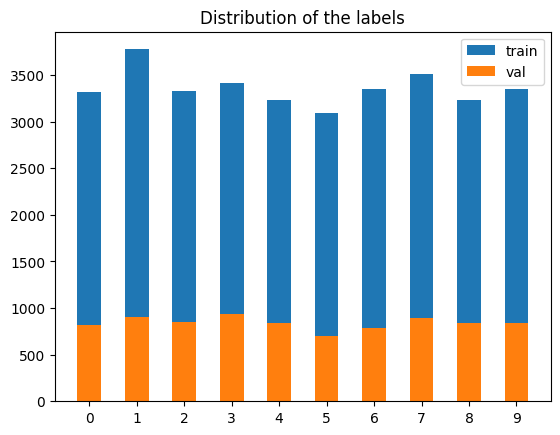

In [4]:
# distribution of the labels
# show the xlabel 1 to 0
plt.xticks(range(11))
plt.hist(y_train, label='train', rwidth=0.5, align='left',bins=range(11))
plt.hist(y_val, label='val', rwidth=0.5, align='left',bins=range(11))
plt.title('Distribution of the labels')
plt.legend()
plt.show()

## data Normalization

In [5]:
# 归一化
X_train = X_train/255.0
X_val = X_val/255.0

# CNN归一化
# data_for_CNN = data_for_CNN/255.0

NameError: name 'X_train_for_CNN' is not defined

## PCA降维数据

# Feedforward Neural Network

In [ ]:
class LinearModel(torch.nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.linear = torch.nn.Linear(784, 10)
    def forward(self, x):
        return self.linear(x)

In [ ]:
Net = LinearModel()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(Net.parameters(), lr=0.01)

X_train_for_LinearModel = torch.tensor(X_train, dtype=torch.float32)
y_train_for_LinearModel = torch.tensor(y_train, dtype=torch.long)
X_val_for_LinearModel = torch.tensor(X_val, dtype=torch.float32)
y_val_for_LinearModel = torch.tensor(y_val, dtype=torch.long)

for epoch in range(100):
    optimizer.zero_grad()
    outputs = Net(X_train_for_LinearModel)
    loss = criterion(outputs, y_train_for_LinearModel)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print('epoch {}, loss {}'.format(epoch, loss.item()))

outputs = Net(X_val_for_LinearModel)
_, predicted = torch.max(outputs, 1)
total = y_val_for_LinearModel.size(0)
correct = (predicted == y_val_for_LinearModel).sum().item()
print('Accuracy: {}'.format(correct/total))

# CNN Model

## super parameter (n_layer, stoppinh criteria, con_kernal)

## Loss function

## Model

In [4]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = torch.nn.Linear(32*7*7, 128)
        self.fc2 = torch.nn.Linear(128, 10)
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = torch.nn.functional.max_pool2d(x, 2)
        x = torch.nn.functional.relu(self.conv2(x))
        x = torch.nn.functional.max_pool2d(x, 2)
        x = x.view(-1, 32*7*7)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
Net = CNN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Net.parameters(), lr=0.001)# choose different optimizer

In [6]:
data_for_CNN = torch.tensor(data_for_CNN).view(-1, 1, 28, 28).to(device)

In [ ]:
# move the model to GPU
Net.to(device)


for epoch in range(30):
    for train_index, val_index in kf.split(data_for_CNN):
        X_train_kfold, X_val_kfold = data_for_CNN[train_index], data_for_CNN[val_index]
        y_train_kfold, y_val_kfold = torch.tensor(label[train_index]).to(device), torch.tensor(label[val_index]).to(device)

        optimizer.zero_grad()
        output = Net(X_train_kfold)
        loss = criterion(output, y_train_kfold)
        loss.backward()
        optimizer.step()

        ##TODO compute the accuracy for each fold
        output = Net(X_val_kfold)
        _, predicted = torch.max(output, 1)
        total = y_val_kfold.size(0)
        correct = (predicted == y_val_kfold).sum().item()
        print('Accuracy: {}'.format(correct/total))
    
    ## TODO ADD up the accuracy of each fold and compute the average accuracy
    

# Save the model
torch.save(Net.state_dict(), 'model.pth')

# Load the model
Net = CNN()
Net.load_state_dict(torch.load('model.pth'))

# Test the model
data = pd.read_csv('train-minst.csv')
data = data.values[:, 1:]
data = data.reshape(data.shape[0], 28, 28)
data = torch.tensor(data, dtype=torch.float32).unsqueeze(1)

output = Net(data)
output = torch.argmax(output, dim=1)
output = output.numpy()

Accuracy: 0.3222857142857143
Accuracy: 0.3954285714285714
Accuracy: 0.5237142857142857
Accuracy: 0.6507142857142857


KeyboardInterrupt: 

In [8]:
data = pd.read_csv('train-minst.csv')
data = data.values[:, 0]
# 合并两个数组
data = np.vstack((data, output))
pd.DataFrame(data.T, columns=['ImageId', 'Label']).to_csv('comp.csv', index=False)
Accuracy = np.sum(data[0] == data[1])/data.shape[1]
print('Accuracy:', Accuracy)

Accuracy: 0.6617142857142857


# KNN

In [39]:
# import knn model
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_val)
Accuracy = np.sum(y_pred == y_val)/y_val.shape[0]
print('Accuracy:', Accuracy)

Accuracy: 0.9666666666666667


In [40]:
# 归一化
X_train = X_train/255.0
X_val = X_val/255.0

In [41]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_val)
Accuracy = np.sum(y_pred == y_val)/y_val.shape[0]
print('Accuracy:', Accuracy)

Accuracy: 0.9666666666666667
